In [1]:
import pymongo
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dateutil import parser
from collections import Counter

from tqdm import tqdm
from sksurv.nonparametric import kaplan_meier_estimator

from scripts import MONGO_URL, END_DATE
from scripts.analysis import data, plot

W, H = 5.5, 2.5
plot.init_matplotlib()

In [2]:
repos = data.get_fake_star_repos()
stars = data.get_fake_stars_by_month()
repos_with_campaign = data.get_repos_with_campaign()
repos = repos[repos.repo_name.isin(repos_with_campaign)]
deleted = set(repos[repos.repo_id.isna()].repo_name)

In [3]:
repos["deleted"] = repos.repo_id.isna()
repos["n_stars_fake"] = repos.n_stars_low_activity + repos.n_stars_clustered
repo_to_len_campaign = Counter(stars[stars.anomaly].repo)
repos["length_campaign"] = repos.repo_name.map(lambda x: repo_to_len_campaign[x])

In [4]:
survival_repo = []
with pymongo.MongoClient(MONGO_URL) as client:
    for repo in tqdm(repos_with_campaign):
        events = list(
            client.fake_stars.fake_repo_events.find({"repo": repo}).sort(
                "created_at", pymongo.ASCENDING
            )
        )
        if len(events) != 0:
            start_date = parser.parse(events[0]["created_at"])
            end_date = parser.parse(events[-1]["created_at"])
            survival_repo.append(
                {
                    "repo": repo,
                    "category": "deleted-re" if repo in deleted else "fake-re",
                    "fake": True,
                    "start_date": start_date,
                    "end_date": end_date,
                    "active_days": (end_date - start_date).days + 1,
                }
            )

    for group in tqdm(
        client.fake_stars.sample_repo_events.aggregate(
            [{"$group": {"_id": "$repo", "created_at": {"$push": "$created_at"}}}]
        )
    ):
        repo = group["_id"]
        events = sorted(group["created_at"])
        start_time = parser.parse(events[0])
        end_time = parser.parse(events[-1])
        survival_repo.append(
            {
                "repo": repo,
                "category": "sample-re",
                "fake": False,
                "start_time": start_time,
                "end_time": end_time,
                "active_days": (end_time - start_time).days + 1,
            }
        )
survival_repo = pd.DataFrame(survival_repo)

100%|██████████| 18617/18617 [02:03<00:00, 151.27it/s]
10000it [00:05, 1737.06it/s]


In [5]:
survival_user = []
fake_user_info = pd.read_csv(f"data/{END_DATE}/fake_user_info.csv")
deleted_users = set(fake_user_info[fake_user_info.error.notnull()].actor)
clustered_users = data.get_unique_actors_in_campaign("clustered")
low_activity_users = data.get_unique_actors_in_campaign("low_activity")
pipeline = [
    {
        "$group": {
            "_id": "$actor",
            "start_time": {"$min": "$created_at"},
            "end_time": {"$max": "$created_at"},
        }
    }
]
with pymongo.MongoClient(MONGO_URL) as client:
    for group in tqdm(client.fake_stars.sample_actor_events.aggregate(pipeline)):
        actor = group["_id"]
        start_time = parser.parse(group["start_time"])
        end_time = parser.parse(group["end_time"])
        survival_user.append(
            {
                "actor": actor,
                "category": "sample-ac",
                "fake": False,
                "clustered": False,
                "start_time": start_time,
                "end_time": end_time,
                "active_days": (end_time - start_time).days + 1,
            }
        )
    for group in tqdm(client.fake_stars.fake_actor_events.aggregate(pipeline)):
        actor = group["_id"]
        start_time = parser.parse(group["start_time"])
        end_time = parser.parse(group["end_time"])
        if actor in low_activity_users or actor in clustered_users:
            survival_user.append(
                {
                    "actor": actor,
                    "category": "deleted-ac" if actor in deleted_users else "fake-ac",
                    "fake": True,
                    "clustered": actor in clustered_users,
                    "start_time": start_time,
                    "end_time": end_time,
                    "active_days": (end_time - start_time).days + 1,
                }
            )
survival_user = pd.DataFrame(survival_user)

10000it [00:01, 7404.46it/s]
10087it [00:01, 7432.52it/s]


In [6]:
Counter(survival_user.clustered)

Counter({False: 10638, True: 1151})

In [7]:
print(
    len(survival_repo[survival_repo.fake]),
    len(survival_repo[survival_repo.fake & (survival_repo.active_days <= 10)]),
)
print(
    len(survival_user[survival_user.fake]),
    len(survival_user[survival_user.fake & (survival_user.active_days <= 10)]),
)

18617 15620
1789 1051


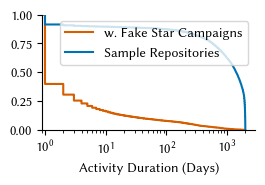

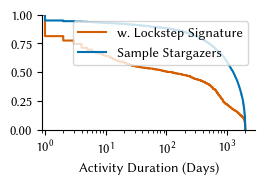

In [8]:
fig, ax = plt.subplots(figsize=(W / 2, H - 1))
sns.ecdfplot(
    data=survival_repo,
    x="active_days",
    hue="fake",
    complementary=True,
    ax=ax,
    palette=["C0", "C2"],
)
ax.set_xscale("log")
ax.set_xlim(0.9)
ax.set_xlabel("Activity Duration (Days)")
ax.set_ylabel("")
ax.legend(["w. Fake Star Campaigns", "Sample Repositories"], loc="upper right")
plot.remove_spines(ax)
fig.savefig("plots/survival_repo.pdf", bbox_inches="tight")

fig, ax = plt.subplots(figsize=(W / 2, H - 1))
sns.ecdfplot(
    data=survival_user[survival_user.clustered | ~survival_user.fake],
    x="active_days",
    hue="fake",
    complementary=True,
    ax=ax,
    palette=["C0", "C2"],
)
ax.legend(["w. Lockstep Signature", "Sample Stargazers"], loc="upper right")
ax.set_xscale("log")
ax.set_xlim(0.9)
ax.set_xlabel("Activity Duration (Days)")
ax.set_ylabel("")
plot.remove_spines(ax)
fig.savefig("plots/survival_user.pdf", bbox_inches="tight")